In [2]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

c:\Users\johng\Documents\Data Science Competition team\big-data-bowl\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('model_data.csv')

In [4]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'gameId', 'playId', 'causedPressure',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'expectedPoints',
       'offenseFormation', 'receiverAlignment', 'playClockAtSnap',
       'passResult', 'passLength', 'targetX', 'targetY', 'playAction',
       'dropbackType', 'dropbackDistance', 'passLocationType', 'timeToThrow',
       'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runC

In [257]:
data['max_gap_influence'] = data[['gap1_influence', 'gap2_influence', 'gap3_influence', 'gap4_influence', 'gap5_influence', 'gap6_influence']].max(axis=1)

#### Potential Feature List

In [258]:

'''
'dlinespread', 'max_distance_to_offense', 'gap1_influence',
       'gap2_influence', 'gap3_influence', 'gap4_influence', 'gap5_influence',
       'gap6_influence', 'avg_def_dist_from_line', 'max_def_dist_from_line',
       'close_endzone', 'close_safety', 'two_minute_drill', 'critical_down',
       'avg_yards_to_go', 'long_distance', 'score_diff',
       'big_score_diff', 'low_play_clock', 'expected_point_bucket',
       'current_pressure_rate'
       '''

In [259]:
data = data.loc[:, ['causedPressure', 'week',
       'close_endzone', 'two_minute_drill', 'critical_down', 
         'long_distance', 'expected_point_bucket',
       'current_pressure_rate', 'max_gap_influence']].dropna() #select features

train/test split <br>
train = weeks1-7 <br>
test = weeks8-9

In [260]:
train = data[~data['week'].isin([8, 9])] 
test = data[data['week'].isin([8, 9])] 

In [261]:
X_train = train.drop(columns=['causedPressure', 'week'])
y_train = train['causedPressure']

X_test = test.drop(columns=['causedPressure', 'week'])
y_test = test['causedPressure'] 

### Hyperparamter Tuning

In [262]:
param_dist = {
    "n_estimators": [125, 150, 175],
    "max_depth": [10, 12, 15],
    "learning_rate": [0.05, 0.01, 0.005],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_lambda": [1, 2, 4],
    "eta": np.logspace(-3, 0, 4)
}

xgb_clf = XGBClassifier(
    objective="binary:logistic", 
    reg_lambda=150,
    scale_pos_weight = 2 # 0 class is twice as likely as 1 class
)


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,            
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    refit='neg_log_loss',         
    cv=3,                    
)

random_search.fit(X_train, y_train)

cv_results = random_search.cv_results_
print(f"Best Parameters: {random_search.best_params_}")

df_cv_results = pd.DataFrame(cv_results)
df_cv_results.sort_values(by=["rank_test_neg_log_loss", "rank_test_f1", "rank_test_roc_auc"], ascending=[True, True, True], inplace=True)
print(f"Min Neg Log Loss = {df_cv_results['mean_test_neg_log_loss'].max():.3f} | Max F1 Score = {df_cv_results['mean_test_f1'].max():.3f} | Max AUC Score = {df_cv_results['mean_test_roc_auc'].max():.3f}")
df_cv_results[["params", "mean_test_neg_log_loss", "rank_test_neg_log_loss", "mean_test_f1", "rank_test_f1", "mean_test_roc_auc", "rank_test_roc_auc"]].head()

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.01, 'eta': np.float64(0.01), 'colsample_bytree': 0.9}
Min Neg Log Loss = -0.664 | Max F1 Score = 0.480 | Max AUC Score = 0.615


,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc
11,"{'subsample': 0.8, 'reg_lambda': 1, 'n_estimat...",-0.663941,1,0.440667,15,0.594132,9
9,"{'subsample': 0.9, 'reg_lambda': 1, 'n_estimat...",-0.666194,2,0.439028,17,0.592495,12
5,"{'subsample': 0.9, 'reg_lambda': 4, 'n_estimat...",-0.666523,3,0.460402,5,0.602193,5
10,"{'subsample': 0.9, 'reg_lambda': 2, 'n_estimat...",-0.668087,4,0.446300,11,0.593750,10
13,"{'subsample': 0.9, 'reg_lambda': 4, 'n_estimat...",-0.668289,5,0.470521,3,0.608107,4


### Model Evaluation and SHAP values

In [263]:
model = random_search.best_estimator_

In [264]:
y_pred = model.predict_proba(X_test)
y_prob = y_pred[:, 1]
y_pred = model.predict(X_test)

In [265]:
roc_auc_score(y_test, y_pred)

np.float64(0.5602890415257488)

In [266]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1334
           1       0.40      0.45      0.42       645

    accuracy                           0.60      1979
   macro avg       0.56      0.56      0.56      1979
weighted avg       0.61      0.60      0.60      1979

[[893 441]
 [354 291]]


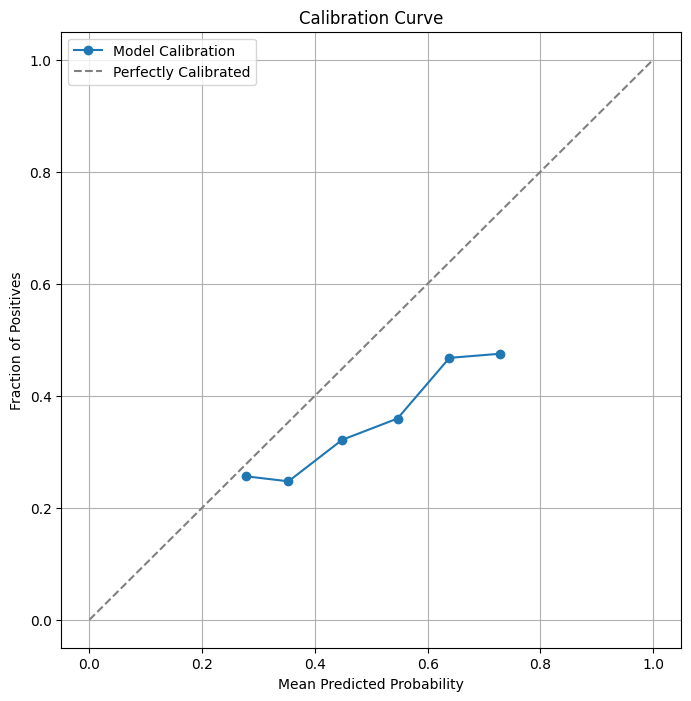

In [267]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

# Step 5: Plot the calibration curve
plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid()
plt.show()

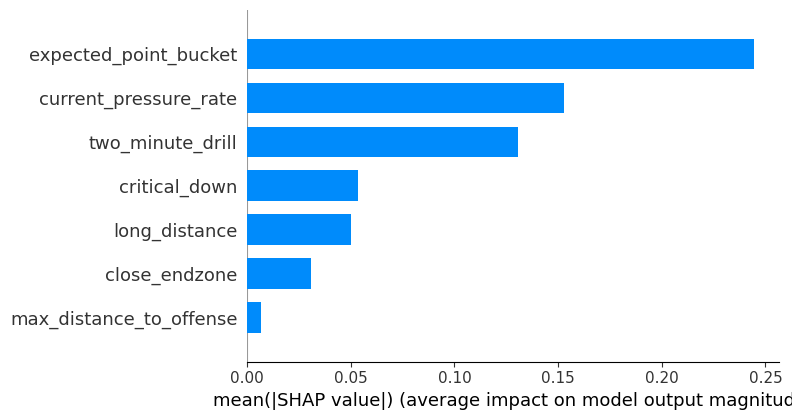

In [270]:
feature_names = ['max_distance_to_offense', 
       'close_endzone', 'two_minute_drill', 'critical_down', 
         'long_distance', 'expected_point_bucket',
       'current_pressure_rate', 'max_gap_influence']

explainer = shap.TreeExplainer(model)
X = data.drop(columns=['causedPressure', 'week'])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names)

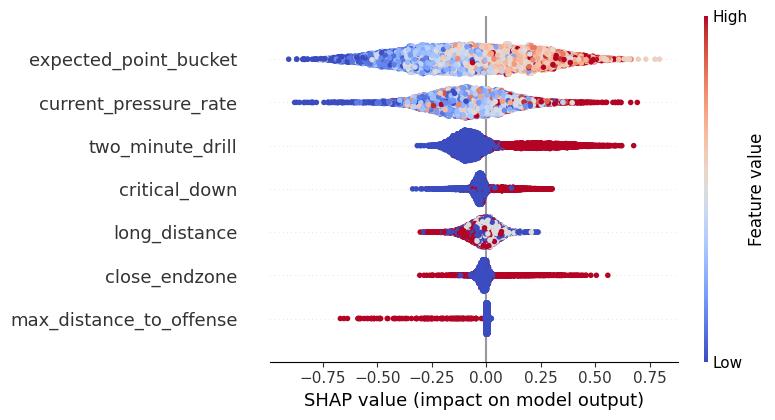

In [271]:
shap.summary_plot(shap_values, X, feature_names=feature_names, cmap="coolwarm")